In [1]:
# barplot
# https://12jeong.github.io/python-barplot/

# plot color
# https://matplotlib.org/stable/gallery/color/named_colors.html

# 신뢰 구간
# https://angie-gil.medium.com/평점-순으로-정렬하지-않는-법-이론편-9ced2f26bc4b

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

In [3]:
train_file = "./train_data.csv"
track_file = "./course.csv"

drop_columns = [
    'index',
    # 'track_K',
]
df_train = pd.read_csv(train_file)
df_train = df_train.drop(drop_columns, axis=1)

drop_columns = [
    'idx',
    # 'grand_prix_K',
    # 'cup_K',
    # 'track_name_K',
]
df_track = pd.read_csv(track_file)
df_track = df_track.drop(drop_columns, axis=1)

In [4]:
df_train.head()

,date,round,game_count,game_goal,cur_game_count,win_odds,lose_odds,track_K,track_E,cc,part_people,rank,prefix_rank,odds_result,significant,RESULT
0,20220204,1,3,15,1,4.71,1.27,와리오 스노 마운틴,Mount Wario,150,10,10,10,straight up,NaN,False
1,20220204,1,3,15,2,4.71,1.27,드래곤 드리프트 로드,Dragon Driftway,mirror,12,7,17,straight up,NaN,False
2,20220204,2,3,15,1,7.04,1.17,와리오 스노 마운틴,Mount Wario,150,11,2,2,underdog,NaN,True
3,20220204,2,3,15,2,7.04,1.17,3DS DK 정글,3DS DK Jungle,150,11,5,7,underdog,NaN,True
4,20220204,2,3,15,3,7.04,1.17,DS 와리오 스타디움,DS Wario Stardium,150,12,5,12,underdog,NaN,True


In [5]:
df_track.head()

,grand_prix_K,grand_prix_E,cup_K,cup_E,track_name_K,track_name_E,significant
0,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,마리오 카트 스타디움,Mario Kart Stadium,NaN
1,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,워터 파크,Water Park,NaN
2,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,스위트 캐니언,Sweet Sweet Canyon,NaN
3,니트로 그랑프리,Nitro Grand Prix,버섯 컵,Mushroom Cup,쿵쿵 유적,Thwomp Ruins,NaN
4,니트로 그랑프리,Nitro Grand Prix,플라워 컵,Flower Cup,마리오 서킷,Mario Circuit,NaN


### 코스별 성공/실패 비율 확인을 위한 dict 선언

In [6]:
track_dict = dict()

for track in df_track['track_name_K']:
    track_dict[track] = dict()
    track_dict[track][True] = track_dict[track][False] = 0

### df_train에서 성공/실패 비율 세기

In [7]:
df_groupby_track = df_train.groupby(['track_K', 'RESULT']).count()

iterable = zip(df_groupby_track['date'].index, df_groupby_track['date'])
for (track, b), value in iterable:
    track_dict[track][b] = value

### plt로 그래프를 그리기 위해 새로운 df 생성

In [8]:
track_name = list()
bTrue, bFalse = list(), list()

for track, value in track_dict.items():
    t = value[True]
    f = value[False]
    
    track_name.append(track)
    bTrue.append(t)
    bFalse.append(f)
    
# track distribution
df_td = pd.DataFrame({
    "성공": bTrue,
    "실패": bFalse,
})

# index에 track 이름 넣기
df_td.index = track_name

# 한 번도 하지 않은 track 제거하기
df_td = df_td.loc[~(df_td == 0).all(axis=1)]
df_td['win_ratio'] = df_td['성공'] / (df_td['성공'] + df_td['실패'])
df_td

,성공,실패,win_ratio
마리오 카트 스타디움,4,6,0.400000
워터 파크,1,2,0.333333
스위트 캐니언,3,6,0.333333
쿵쿵 유적,3,9,0.250000
마리오 서킷,3,11,0.214286
...,...,...,...
Tour 로마 아반티,0,1,0.000000
GC DK 마운틴,0,1,0.000000
Tour 마드리드 그란데,1,0,1.000000
SFC 쿠파 성 3,0,2,0.000000


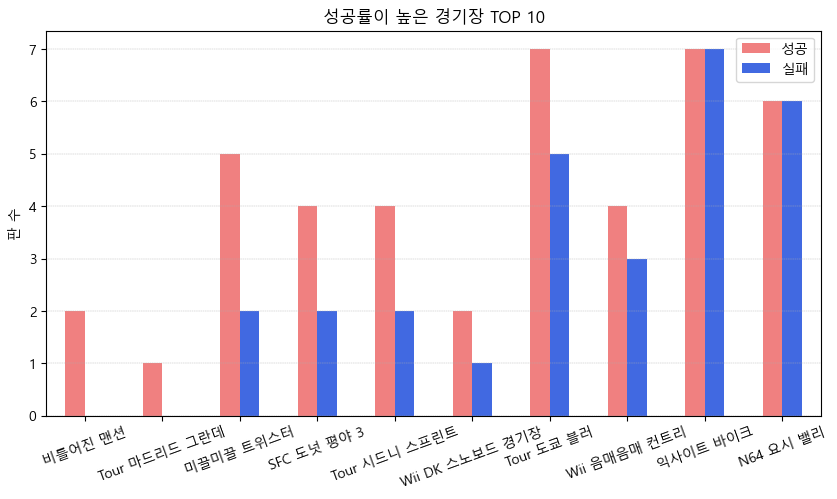

In [9]:
df_td = df_td.sort_values(['win_ratio', '성공'], ascending=False)

df_td.head(10).plot.bar(
    y=['성공', '실패'],
    color=['lightcoral', 'royalblue'],
    figsize=(10, 5),
    rot=20,
)

plt.title("성공률이 높은 경기장 TOP 10")
plt.ylabel("판 수")
plt.grid(True, linestyle='--', linewidth=0.3, axis='y')

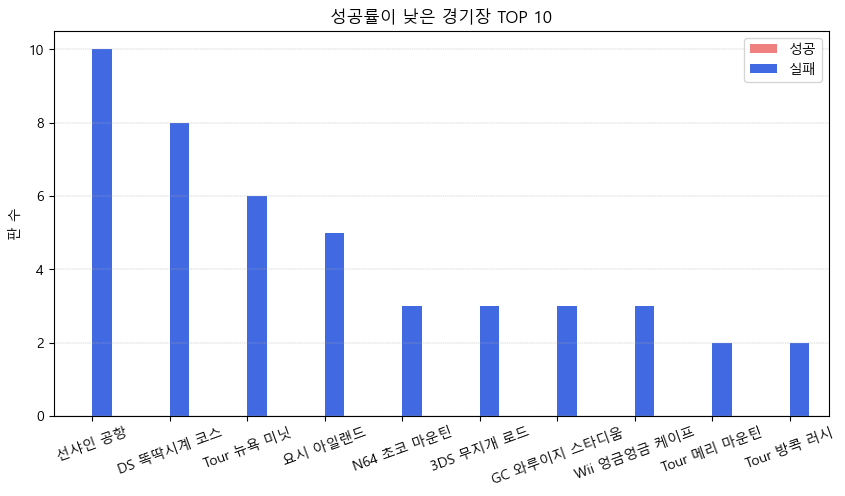

In [10]:
df_td = df_td.sort_values(['win_ratio', '실패'], ascending=[True, False])

df_td.head(10).plot.bar(
    y=['성공', '실패'],
    color=['lightcoral', 'royalblue'],
    figsize=(10, 5),
    rot=20,
)

plt.title("성공률이 낮은 경기장 TOP 10")
plt.ylabel("판 수")
plt.grid(True, linestyle='--', linewidth=0.3, axis='y')

### 코스별 집계 함수 결과 확인하기 & 파생 변수 만들기

In [11]:
df_rank = df_train.groupby(['track_K'])['rank'].agg([
    'mean', 'max', 'min', 'count', 'std',
])

df_rank['frequency'] = df_rank['count'] / sum(df_rank['count'])
df_rank['coef_var'] = df_rank['std'] / df_rank['mean']
df_rank['win_ratio'] = df_rank.index.map(df_td['win_ratio'])
df_rank['standard'] = df_rank['frequency'] * df_rank['win_ratio']
df_rank.head()

,mean,max,min,count,std,frequency,coef_var,win_ratio,standard
track_K,,,,,,,,,
3DS DK 정글,5.714286,12,1,7,3.450328,0.011076,0.603807,0.428571,0.004747
3DS 네오 쿠파 시티,7.083333,11,4,12,2.678478,0.018987,0.378138,0.250000,0.004747
3DS 록 록 마운틴,7.000000,12,4,5,3.162278,0.007911,0.451754,0.200000,0.001582
3DS 무지개 로드,7.000000,11,3,3,4.000000,0.004747,0.571429,0.000000,0.000000
3DS 뮤직 파크,4.333333,7,2,3,2.516611,0.004747,0.580756,0.333333,0.001582


### wilson score 점수 반영하기

In [12]:
from scipy import stats
import math

def handmade_wilson_score(pos: int, total: int) -> float:
    confidence = 0.95
    z = stats.norm.ppf(1 - (1-confidence) / 2)
    phat = 1.0 * pos / total
    lower_bound = (phat + z*z/(2*total) - z * math.sqrt((phat*(1-phat)+z*z/(4*total))/total))/(1+z*z/total)
    return lower_bound


from statsmodels.stats.proportion import proportion_confint

def wilson_score(pos: int, total: int) -> float:
    return proportion_confint(pos, total, method='wilson')

In [13]:
def get_lower_bound(row):
    return proportion_confint(row['win_count'], row['count'], method='wilson')[0]

df_rank['win_count'] = df_rank.index.map(df_td['성공'])
df_rank['lower_bound'] = df_rank.apply(get_lower_bound, axis=1)
df_rank.head()

,mean,max,min,count,std,frequency,coef_var,win_ratio,standard,win_count,lower_bound
track_K,,,,,,,,,,,
3DS DK 정글,5.714286,12,1,7,3.450328,0.011076,0.603807,0.428571,0.004747,3,0.158220
3DS 네오 쿠파 시티,7.083333,11,4,12,2.678478,0.018987,0.378138,0.250000,0.004747,3,0.088942
3DS 록 록 마운틴,7.000000,12,4,5,3.162278,0.007911,0.451754,0.200000,0.001582,1,0.036224
3DS 무지개 로드,7.000000,11,3,3,4.000000,0.004747,0.571429,0.000000,0.000000,0,0.000000
3DS 뮤직 파크,4.333333,7,2,3,2.516611,0.004747,0.580756,0.333333,0.001582,1,0.061492


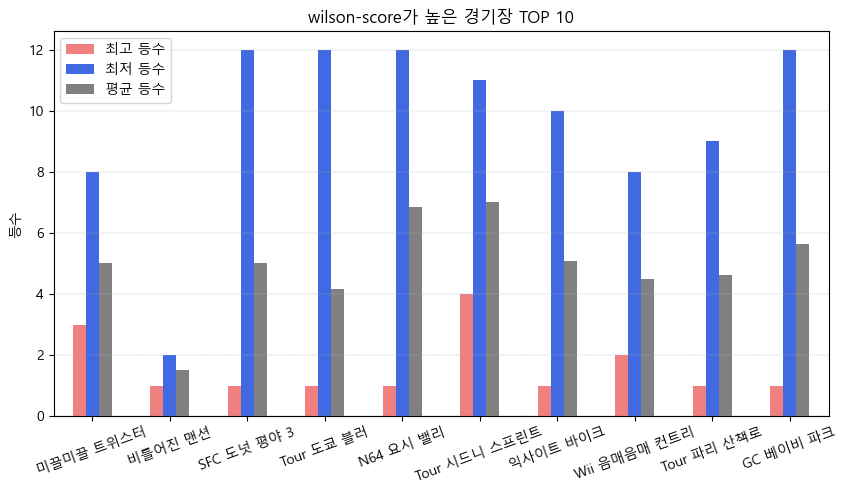

In [18]:
df_rank = df_rank.sort_values('lower_bound', ascending=False)

df_rank.head(10).plot.bar(
    y = ['min', 'max', 'mean',],
    color = ['lightcoral', 'royalblue', 'grey',],
    figsize = (10, 5),
    rot = 20,
)

plt.title("wilson-score가 높은 경기장 TOP 10")
plt.xlabel("")
plt.ylabel("등수")
plt.legend(["최고 등수", "최저 등수", "평균 등수",])
plt.grid(True, linestyle='--', linewidth=0.3, axis='y')

# TRUE, FALSE 비교

In [15]:
df_train['RESULT'].value_counts()

RESULT
False    443
True     180
Name: count, dtype: int64

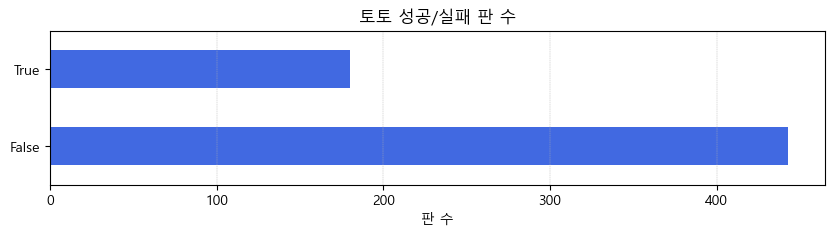

In [16]:
df_train['RESULT'].value_counts().plot.barh(
    color = "royalblue",
    figsize = (10, 2),
)

plt.title("토토 성공/실패 판 수")
plt.xlabel("판 수")
plt.ylabel("")
plt.grid(True, linestyle='--', linewidth=0.3, axis='x')

# 날짜별 승률 및 평균 등수 확인

In [17]:
# drop row
df_date = df_train.loc[df_train['significant'].isna()]

drop_columns = [
    "track_K",
    "track_E",
    "round",
    "game_count",
    "game_goal",
    "cur_game_count",
    "prefix_rank",
    "significant",
]

# drop col
df_date = df_date.drop(drop_columns, axis=1)

# value change
df_date['RESULT'] = df_date['RESULT'].replace(False, 0).replace(True, 1)
df_date['cc'] = df_date['cc'].replace("mirror", 150)
df_date['odds_result'] = df_date['odds_result'].replace("straight up", 0).replace("underdog", 1)

df_date

,date,win_odds,lose_odds,cc,part_people,rank,odds_result,RESULT
0,20220204,4.71,1.27,150,10,10,0,0
1,20220204,4.71,1.27,150,12,7,0,0
2,20220204,7.04,1.17,150,11,2,1,1
3,20220204,7.04,1.17,150,11,5,1,1
4,20220204,7.04,1.17,150,12,5,1,1
...,...,...,...,...,...,...,...,...
627,20231222,7.16,1.16,150,11,9,0,0
628,20231222,8.24,1.14,150,12,12,0,0
629,20231222,1.87,2.15,150,8,6,1,0
630,20231222,1.87,2.15,150,9,6,1,0


## 데이터 전처리: 결측치 제거

In [191]:
for column in df_date.columns:
    df_date = df_date.loc[~df_date[column].isna()]
    
df_date

,date,win_odds,lose_odds,cc,part_people,rank,odds_result,RESULT
0,20220204,4.71,1.27,150,10,10,0,0
1,20220204,4.71,1.27,150,12,7,0,0
2,20220204,7.04,1.17,150,11,2,1,1
3,20220204,7.04,1.17,150,11,5,1,1
4,20220204,7.04,1.17,150,12,5,1,1
...,...,...,...,...,...,...,...,...
627,20231222,7.16,1.16,150,11,9,0,0
628,20231222,8.24,1.14,150,12,12,0,0
629,20231222,1.87,2.15,150,8,6,1,0
630,20231222,1.87,2.15,150,9,6,1,0


## 데이터 전처리: error 및 noise 제거

In [192]:
# error 제거
df_date['win_odds'] = df_date['win_odds'].str.replace("..", ".", regex=False)
# error 확인
df_date.loc[df_date['win_odds'].str.contains("\.\.", na=True)]

# type 변경
df_date['win_odds'] = df_date['win_odds'].apply(float)
df_date['lose_odds'] = df_date['lose_odds'].apply(float)
df_date['cc'] = df_date['cc'].apply(int)

## 데이터 확인하기

In [211]:
columns = [
#     "win_odds",
#     "lose_odds",
#     "cc",
     "rank",
#     "odds_result",
#     "RESULT",
]

df_bar = df_date.groupby(["date"])[columns].agg(["count", "mean", "min", "max"])
df_bar

rank                  
         count      mean min max
date                            
20220204    55  6.454545   1  12
20220412    26  6.230769   1  11
20220526    19  5.894737   2  12
20220722    39  5.794872   1  11
20220805    45  5.844444   1  12
20221013    52  6.384615   1  12
20221130    33  5.272727   1  12
20221223    19  5.736842   2  11
20230221    13  7.538462   1  12
20230407    22  5.954545   1  12
20230414    21  6.285714   1  11
20230420    41  7.731707   1  12
20230630    40  6.275000   2  12
20230705    39  6.487179   1  12
20230812    19  6.842105   1  12
20230821    25  7.080000   1  12
20230822    21  5.809524   1  11
20230921    10  8.400000   4  11
20231023    28  7.392857   1  12
20231205    43  6.627907   1  12
20231222    10  8.200000   6  12

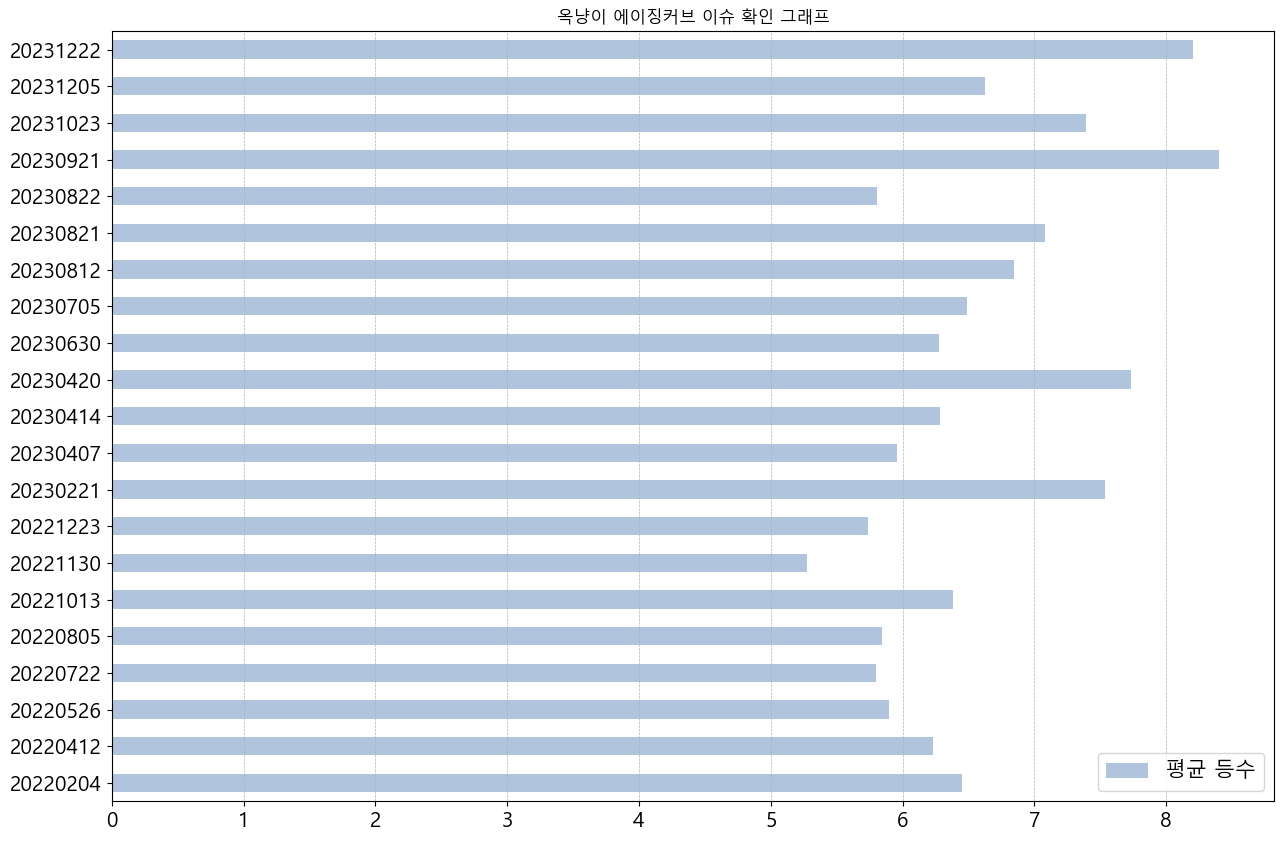

In [291]:
df_bar.plot.barh(
    title = "옥냥이 에이징커브 이슈 확인 그래프",
    y = [('rank', 'mean'), ],
    label = ["평균 등수", ],
    color = ["lightsteelblue", ],
    xlabel = "",
    ylabel = "",
    figsize = (15, 10),
    rot = 0,
    fontsize = 15
)

plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.legend(fontsize=15)

([<matplotlib.axis.XTick at 0x17385fb7b90>,
 [Text(0, 0, '20220204'),
  Text(1, 0, '20220412'),
  Text(2, 0, '20220526'),
  Text(3, 0, '20220722'),
  Text(4, 0, '20220805'),
  Text(5, 0, '20221013'),
  Text(6, 0, '20221130'),
  Text(7, 0, '20221223'),
  Text(8, 0, '20230221'),
  Text(9, 0, '20230407'),
  Text(10, 0, '20230414'),
  Text(11, 0, '20230420'),
  Text(12, 0, '20230630'),
  Text(13, 0, '20230705'),
  Text(14, 0, '20230812'),
  Text(15, 0, '20230821'),
  Text(16, 0, '20230822'),
  Text(17, 0, '20230921'),
  Text(18, 0, '20231023'),
  Text(19, 0, '20231205'),
  Text(20, 0, '20231222')])

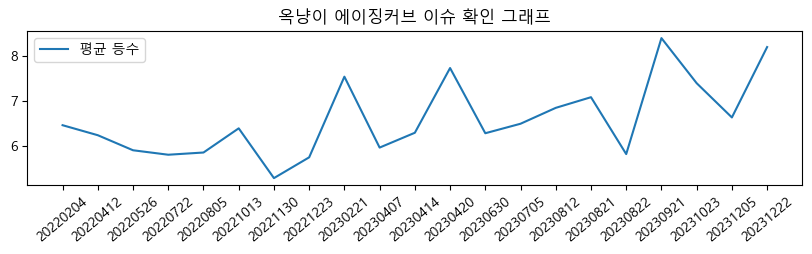

In [290]:
df_tmp = pd.DataFrame({
    # "date": map(str, df_bar.index),
    "mean_rank": df_bar['rank']['mean'].tolist(),
    # "bottom_rank": df_bar['rank']['max'].tolist(),
    # "top_rank": df_bar['rank']['min'].tolist(),
})
df_tmp.index = map(str, df_bar.index)

df_tmp.plot(
    title = "옥냥이 에이징커브 이슈 확인 그래프",
    y = ["mean_rank"],
    label = ["평균 등수"],
    figsize = (10, 2),
    rot = 40,
)

length = len(list(map(str, df_bar.index)))
plt.xticks(
    [i for i in range(length)],
    labels = list(map(str, df_bar.index)),
)

## 참가 인원 확인 (리방 확률 확인용)